In [1]:

# Author: Shilin Zhang
# Created Date: 13 June 2022

# Description:
# Replication work of the paper: 
# Optimal selection of time lags for TDSEP based on genetic algorithm

# Related Paper:
# TDSEP - an efficient algorithm for blind separation using time structure

# Method of determning the optimal lag: 
# Indenpendent Component Analysis (ICA)
# Genetic Algorithm (GA)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plot
import yfinance as yf
from numpy.random import randint
from numpy.random import rand

In [3]:
# read the data from yahoo finance
startdate = '2020-09-01'
enddate = '2022-02-01'
datasource = 'SPY'
data = yf.download(datasource,start = startdate,end = enddate)

[*********************100%***********************]  1 of 1 completed


In [4]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-08-31,350.350006,351.299988,349.059998,349.309998,339.358582,66099200
2020-09-01,350.209991,352.709991,349.239990,352.600006,342.554840,54908700
2020-09-02,354.670013,358.750000,353.429993,357.700012,347.509521,69540000
2020-09-03,355.869995,356.380005,342.589996,345.390015,335.550262,148011100
2020-09-04,346.130005,347.829987,334.869995,342.570007,332.810547,139156300
...,...,...,...,...,...,...
2022-01-25,433.059998,439.720001,427.149994,434.470001,431.261536,167997300
2022-01-26,440.720001,444.040009,428.859985,433.380005,430.179596,186391100
2022-01-27,438.260010,441.589996,429.450012,431.239990,428.055389,149878300


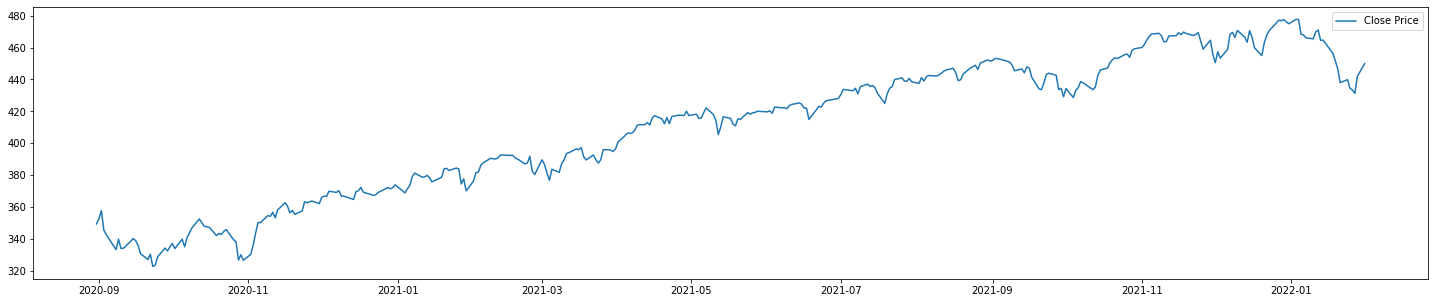

In [5]:
plot.figure(figsize=(25,5))
plot.plot(data['Close'],label='Close Price')
plot.legend()

In [6]:
# observations matrix X

from sklearn.preprocessing import MinMaxScaler

cols = ['Open', 'High', 'Low', 'Adj Close','Volume','Close']
mmscaler = MinMaxScaler()
data[cols] = mmscaler.fit_transform(data[cols])
X = data[cols].to_numpy()
X = X.T

In [7]:
X.shape

(6, 358)

In [8]:
def center(x):
    mean = np.mean(x, axis=1, keepdims=True)
    centered =  x - mean
    return centered, mean

# calculate the covariance matrix of six observed time series
def covariance(x):
    mean = np.mean(x, axis=1, keepdims=True)
    n = np.shape(x)[1] - 1
    m = x - mean

    return (m.dot(m.T))/n

In [9]:
def whiten(X):
    # Calculate the covariance matrix
    covarMatrix = covariance(X)

    # Single value decoposition
    U, S, V = np.linalg.svd(covarMatrix)

    # Calculate diagonal matrix of eigenvalues
    d = np.diag(1.0 / np.sqrt(S))

    # Calculate whitening matrix
    whiteM = np.dot(U, np.dot(d, U.T))

    # Project onto whitening matrix
    Z = np.dot(whiteM, X)

    return Z, whiteM

In [10]:
X_center, meanX = center(X)

In [11]:
X_center

array([[-0.37557559, -0.37646176, -0.34823378, ...,  0.18081683,
         0.14550027,  0.19967747],
       [-0.39500232, -0.38579744, -0.34636665, ...,  0.19443491,
         0.19711153,  0.25116556],
       [-0.3722311 , -0.37107922, -0.34426492, ...,  0.14223204,
         0.13180067,  0.2085317 ],
       [-0.39871311, -0.37867124, -0.34760334, ...,  0.15745263,
         0.2241129 ,  0.2736566 ],
       [-0.04720245, -0.09686605, -0.03193213, ...,  0.32461039,
         0.38931264,  0.33514224],
       [-0.38922743, -0.36801115, -0.33512273, ...,  0.13911464,
         0.20818037,  0.25951198]])

In [12]:
Z,whiteM = whiten(X_center)

In [13]:
Z

array([[-0.5670718 , -0.94114943, -1.43948067, ...,  1.00828404,
        -1.55306414, -2.38088744],
       [-0.96570784, -0.61233818,  0.1856434 , ...,  1.89541021,
         0.26303377,  0.40041769],
       [ 0.45256615, -0.88781317, -0.9050705 , ..., -0.16133813,
        -2.52111171, -0.08662831],
       [-1.88841386, -1.46951038, -2.02730982, ...,  1.23986039,
         3.3715472 ,  2.77625055],
       [-0.30883413, -0.73306067, -0.28552923, ...,  2.19079488,
         2.70816121,  2.45849913],
       [-0.17606462,  0.81809976,  1.34766569, ..., -2.61304559,
         1.89872323,  1.2144292 ]])

In [14]:
print(np.round(covariance(Z)))

[[ 1.  0.  0.  0. -0. -0.]
 [ 0.  1. -0.  0. -0.  0.]
 [ 0. -0.  1. -0.  0.  0.]
 [ 0.  0. -0.  1. -0.  0.]
 [-0. -0.  0. -0.  1.  0.]
 [-0.  0.  0.  0.  0.  1.]]


In [15]:
Z.shape

(6, 358)

In [16]:
# Independent Component Analysis
# X = S * A.T
# By using ICA, we could approximate original signal matrix S

from sklearn.decomposition import FastICA

transformer = FastICA(n_components=6,
                      random_state=0,
                      whiten='unit-variance',
                      fun='logcosh')
S = transformer.fit_transform(X.T).T

In [17]:
S.shape

(6, 358)

In [18]:
# Calculate Rotation Matrix Q

# covariance matrix of Z with tau  = Q_T * covariance matrix of S with tau * Q
# TDSEP - an efficient algorithm for blind separation using time structure

# Calculate the average covariance matrix with a list of lags

def covariance_with_lag(x,lags):
    matrix = np.empty((6, 6), float)
    for i in lags:
        x1 = x[:,i:n]
        x2 = x[:,0:n-lag]
        mean1 = np.mean(x1, axis=1, keepdims=True)
        mean1 = np.mean(x2, axis=1, keepdims=True)
        n = np.shape(x1)[1] - 1
        m1 = x1 - mean1
        m2 = x2 - mean2
        matrix = matrix + m1.dot(m2.T)/n
    return matrix/len(lag)

# Compute the orthogonal matrix Q via approximate simultaneous diagonalization

def generate_Q(Z,lags):
    # Set a fixed Q for testing
    Q = np.array([[1,1,1,1,1,1],
     [1,1,1,1,1,1],
     [1,1,1,1,1,1],
     [1,1,1,1,1,1],
     [1,1,1,1,1,1],
     [1,1,1,1,1,1]])
    return Q

In [19]:
# Negentropy Estimation

# One of the estimation function G1 
def G(x):
    return 1/a_1 * np.cosh(a_1 * x)

def J(Y):
    row,col = Y.shape
    J = 0
    for i in range(0,col):
        sum1 = 0
        sum2 = 0
        for j in Y[:,i]:
            sum1 = sum1 + G(j)
            v = np.random.normal(0,1)
            sum2 = sum2 + + G(v)
        E_Y = sum1/row
        E_V = sum2/row
        J = J + (E_Y - E_V) ** 2
    return J

In [20]:
# genetic algorithm search for optimization problem


# objective function
def obj(x):
    Q = generate_Q(Z,x)
    Y = Q @ Z
    result  = n_d * J(Y)/sum(x)
    return -result

# tournament selection
def selection(pop, scores, k=3):
    # first random selection
    selection_ix = randint(len(pop))
    for ix in randint(0, len(pop), k-1):
        # check if better (e.g. perform a tournament)
        if scores[ix] < scores[selection_ix]:
            selection_ix = ix
    return pop[selection_ix]

# crossover two parents to create two children
def crossover(p1, p2, r_cross):
    # children are copies of parents by default
    c1, c2 = p1.copy(), p2.copy()
    # check for recombination
    if rand() < r_cross:
        # select crossover point that is not on the end of the string
        pt = randint(1, len(p1)-2)
        # perform crossover
        c1 = p1[:pt] + p2[pt:]
        c2 = p2[:pt] + p1[pt:]
    return [c1, c2]

# mutation operator
def mutation(bitstring, r_mut):
    for i in range(len(bitstring)):
        # check for a mutation
        if rand() < r_mut:
            # flip the bit
            bitstring[i] = 1 - bitstring[i]

In [21]:
# genetic algorithm

def genetic_algorithm(objective, n_bits, n_iter, n_pop, r_cross, r_mut):
    # initial population of random bitstring
    pop = [randint(0, 2, n_bits).tolist() for _ in range(n_pop)]
    # keep track of best solution
    best, best_eval = 0, objective(pop[0])
    # enumerate generations
    for gen in range(n_iter):
        # evaluate all candidates in the population
        scores = [objective(c) for c in pop]
        # check for new best solution
        for i in range(n_pop):
            if scores[i] < best_eval:
                best, best_eval = pop[i], scores[i]
                # print(">%d, new best f(%s) = %.3f" % (gen,  pop[i], scores[i]))
                print("iteration: %d, number of lags: %d, score: %.3f" %(gen, sum(pop[i]), scores[i]))
        # select parents
        selected = [selection(pop, scores) for _ in range(n_pop)]
        # create the next generation
        children = list()
        for i in range(0, n_pop, 2):
            # get selected parents in pairs
            p1, p2 = selected[i], selected[i+1]
            # crossover and mutation
            for c in crossover(p1, p2, r_cross):
                # mutation
                mutation(c, r_mut)
                # store for next generation
                children.append(c)
        # replace population
        pop = children
    return [best, best_eval]

In [22]:
# Parameter Setting

# length of an individual/ maximum tau
n_d = 100
# number of generation
n_g = 500
# number of population
n_p = 100
# crossover prob
p_c = 0.85
# mutation prob
p_m = 0.05

# parameter for negentropy estimation
a_1 = 1.5


In [23]:
best, score = genetic_algorithm(obj, n_d, n_g, n_p, p_c, p_m)
print('Done!')
print('f(%s) = %f' % (best, score))

iteration: 0, number of lags: 50, score: -243789607.188
iteration: 0, number of lags: 49, score: -248847111.107
iteration: 0, number of lags: 43, score: -283500947.326
iteration: 0, number of lags: 42, score: -290250078.656
iteration: 0, number of lags: 38, score: -320797804.460
iteration: 1, number of lags: 38, score: -320798546.786
iteration: 2, number of lags: 37, score: -329528858.428
iteration: 2, number of lags: 36, score: -338674379.342
iteration: 3, number of lags: 34, score: -358572737.878
iteration: 4, number of lags: 32, score: -381026868.378
iteration: 5, number of lags: 30, score: -406280919.729
iteration: 6, number of lags: 30, score: -406447735.442
iteration: 6, number of lags: 28, score: -435246037.435
iteration: 7, number of lags: 27, score: -451587629.050
iteration: 8, number of lags: 26, score: -468960591.521
iteration: 9, number of lags: 25, score: -487560818.843
iteration: 9, number of lags: 24, score: -507933588.763
iteration: 10, number of lags: 23, score: -53013

In [24]:
table = pd.DataFrame(best,columns = ['lag'])

best_lag_list = []
for i in range(0,100):
    if table.iloc[i][0] == 1:
        best_lag_list.append(i+1)
        
best_lag_list

[8, 9, 14, 18, 20, 26, 39, 50, 59, 74, 78]

### Traning Set Preparation

Calculate the rotation matrix Q for training set
Calculate indepdent component matrix Y for training set
Using the lags trained from the previous step and  indepdent component matrix Y to construct the prediction model input

In [25]:
# Prepare the training and testing data set (80:20)

startdate_training = '2020-09-01'
enddate_training = '2022-02-01'
startdate_testing = '2022-02-01'
enddate_testing = '2022-06-01'
datasource = 'SPY'
training_set = yf.download(datasource,start = startdate_training,end = enddate_training)
testing_set = yf.download(datasource,start = startdate_testing,end = enddate_testing)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [26]:
def training_preparation(training_set,lags):
    cols = ['Open', 'High', 'Low', 'Adj Close','Volume','Close']
    mmscaler = MinMaxScaler()
    training_set[cols] = mmscaler.fit_transform(training_set[cols])
    X = training_set[cols].to_numpy()
    X = X.T
    
    X_center, meanX = center(X)
    Z,whiteM = whiten(X_center)
    
    Q = generate_Q(Z,lags)
    Y = Q @ Z
    return Q,Y.T

In [27]:
Q_training, Y_training = training_preparation(training_set,best_lag_list)

In [28]:
Y_training

array([[-3.45352615, -3.45352615, -3.45352615, -3.45352615, -3.45352615,
        -3.45352615],
       [-3.8257721 , -3.8257721 , -3.8257721 , -3.8257721 , -3.8257721 ,
        -3.8257721 ],
       [-3.1240813 , -3.1240813 , -3.1240813 , -3.1240813 , -3.1240813 ,
        -3.1240813 ],
       ...,
       [ 3.55996589,  3.55996589,  3.55996589,  3.55996589,  3.55996589,
         3.55996589],
       [ 4.16728974,  4.16728974,  4.16728974,  4.16728974,  4.16728974,
         4.16728974],
       [ 4.38208097,  4.38208097,  4.38208097,  4.38208097,  4.38208097,
         4.38208097]])

In [29]:
Y_training.shape

(358, 6)

In [30]:
def testing_preparation(testing_set,Q_training):
    cols = ['Open', 'High', 'Low', 'Adj Close','Volume','Close']
    mmscaler = MinMaxScaler()
    testing_set[cols] = mmscaler.fit_transform(testing_set[cols])
    X = testing_set[cols].to_numpy()
    X = X.T
    
    X_center, meanX = center(X)
    Z,whiteM = whiten(X_center)
    
    Q = Q_training
    Y = Q @ Z
    return Y.T

In [32]:
Y_testing = testing_preparation(testing_set,Q_training)

In [33]:
Y_testing.shape

(83, 6)

In [34]:
# save training set and testing set as csv file

training_df = pd.DataFrame(Y_training, columns=cols)
testing_df = pd.DataFrame(Y_testing, columns=cols)

In [35]:
testing_df

,Open,High,Low,Adj Close,Volume,Close
0,3.486754,3.486754,3.486754,3.486754,3.486754,3.486754
1,3.945269,3.945269,3.945269,3.945269,3.945269,3.945269
2,2.801694,2.801694,2.801694,2.801694,2.801694,2.801694
3,2.663597,2.663597,2.663597,2.663597,2.663597,2.663597
4,1.318984,1.318984,1.318984,1.318984,1.318984,1.318984
...,...,...,...,...,...,...
78,-5.547033,-5.547033,-5.547033,-5.547033,-5.547033,-5.547033
79,-5.079125,-5.079125,-5.079125,-5.079125,-5.079125,-5.079125
80,-4.662657,-4.662657,-4.662657,-4.662657,-4.662657,-4.662657
81,-3.272813,-3.272813,-3.272813,-3.272813,-3.272813,-3.272813


In [37]:
Y_df = pd.concat([training_df,testing_df])

In [40]:
Y_df

,Open,High,Low,Adj Close,Volume,Close
0,-3.453526,-3.453526,-3.453526,-3.453526,-3.453526,-3.453526
1,-3.825772,-3.825772,-3.825772,-3.825772,-3.825772,-3.825772
2,-3.124081,-3.124081,-3.124081,-3.124081,-3.124081,-3.124081
3,-1.114334,-1.114334,-1.114334,-1.114334,-1.114334,-1.114334
4,-1.718198,-1.718198,-1.718198,-1.718198,-1.718198,-1.718198
...,...,...,...,...,...,...
78,-5.547033,-5.547033,-5.547033,-5.547033,-5.547033,-5.547033
79,-5.079125,-5.079125,-5.079125,-5.079125,-5.079125,-5.079125
80,-4.662657,-4.662657,-4.662657,-4.662657,-4.662657,-4.662657
81,-3.272813,-3.272813,-3.272813,-3.272813,-3.272813,-3.272813


In [44]:
from pathlib import Path  
filepath = Path('C:/Users/82422/OneDrive/internship/Optimal Lag/Data/Data.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)  
Y_df.to_csv(filepath)